## 下載訓練資料跟測試資料

In [ ]:
!nvidia-smi

Tue Jun  8 10:14:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 事先將資料放到 googld drive
- 訓練資料
- Public 測試資料
- Private 測試資料
- 下載到 google colab

In [1]:
workspace_dir = '.'
!gdown --id 1jibt2P13I-7AZ7Ayt2avaIeJkmsIDWha --output "{workspace_dir}/train.zip"
!gdown --id 1BLS5HZocGXAskT_RzrOYDLl7kEj75ir0 --output "{workspace_dir}/public_test.zip"
!unzip -q "{workspace_dir}/train.zip" -d "{workspace_dir}/"
!unzip -q "{workspace_dir}/public_test.zip" -d "{workspace_dir}/"

!gdown --id 1SN7DiiD9bK3ZrrGV9F-XOD1N4F65F4L2 --output "{workspace_dir}/private_test.zip"
!unzip -q "{workspace_dir}/private_test.zip" -d "{workspace_dir}/"

Downloading...
From: https://drive.google.com/uc?id=1jibt2P13I-7AZ7Ayt2avaIeJkmsIDWha
To: /content/train.zip
74.3MB [00:00, 144MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1BLS5HZocGXAskT_RzrOYDLl7kEj75ir0
To: /content/public_test.zip
699MB [00:04, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SN7DiiD9bK3ZrrGV9F-XOD1N4F65F4L2
To: /content/private_test.zip
1.40GB [00:11, 119MB/s] 


In [2]:
# 下載 efficientnet 
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=ecde8bbcfdf8515fc8212bebdab735af163198c18c62488dbfc372241403a8b6
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


## 套件載入

In [4]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss
import torchvision
from efficientnet_pytorch import EfficientNet

import librosa
import librosa.display

from pathlib import Path
from IPython.display import Audio

from tqdm import tqdm_notebook
import tqdm
# from tqdm import tqdm


from scipy.io import wavfile
import matplotlib.pyplot as plt
import random

from google.colab import drive


from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import shutil
import pickle
from copy import deepcopy


drive.mount('/content/gdrive', force_remount=True)

meta_train = pd.read_csv('meta_train.csv')

Mounted at /content/gdrive


## 製造頻譜圖

In [ ]:
# 製作頻譜圖
def get_melspec(prefix, file_name):
  y, sr = librosa.load(f'{prefix}/{file_name}.wav', sr = 8000)
  if len(y)<sr*5:
      print(prefix,file_name)
      l = sr*5-len(y)
      y = np.hstack([y,np.zeros(l)])
  mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y, sr=sr, n_mels=128,n_fft=1024, hop_length=256))
  return mel_spec

train_sepc = []
for file_name in tqdm.notebook.tqdm(meta_train.Filename):
    train_sepc.append(get_melspec('train',file_name))



public_test_file_name = os.listdir('public_test')
public_test_file_name.sort()
public_test_file_name = [i[:-4] for i in public_test_file_name]
public_test_spec = []
for file_name in tqdm_notebook(public_test_file_name):
    public_test_spec.append(get_melspec('public_test',file_name))


private_test_file_name = os.listdir('private_test')
private_test_file_name.sort()
private_test_file_name = [i[:-4] for i in private_test_file_name]
private_test_spec = []
for file_name in tqdm_notebook(private_test_file_name):
    private_test_spec.append(get_melspec('private_test',file_name))

np.save('gdrive/MyDrive/tbrain_dog_2/train_spec_0608.npy',np.array(train_sepc))
np.save('gdrive/MyDrive/tbrain_dog_2/public_test_spec_0608.npy',np.array(public_test_spec))
np.save('gdrive/MyDrive/tbrain_dog_2/private_test_spec_0608.npy',np.array(private_test_spec))


train train_01046



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [23]:
train_sepc = np.load('gdrive/MyDrive/tbrain_dog_2/train_spec_0608.npy')
public_test_spec = np.load('gdrive/MyDrive/tbrain_dog_2/public_test_spec_0608.npy')
private_test_spec = np.load('gdrive/MyDrive/tbrain_dog_2/private_test_spec_0608.npy')

## 頻譜圖範例

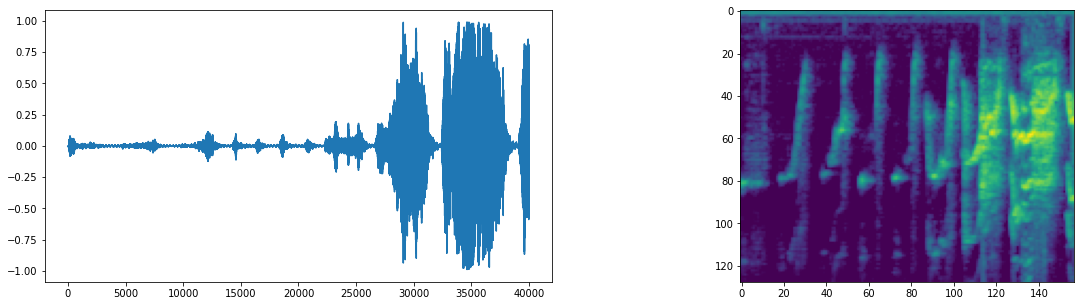

In [6]:
file_name = meta_train.iloc[500,0]
y, sr = librosa.load(f'train/{file_name}.wav', duration=10,sr = 8000)
mel_spec = librosa.feature.melspectrogram(y, sr=sr, n_mels=128,n_fft=1024, hop_length=256)
mel_spec = librosa.power_to_db(mel_spec)
# mel_spec = mel_spec / 255
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [10, 10]}, figsize = (20,5))
a0.plot(y)
a1.imshow(mel_spec)
Audio(y, rate=sr)

## 數據增強(針對頻譜圖)

In [ ]:
# 資料增強(SpecAugment)
def spec_augment(spec: np.ndarray, num_mask=3, 
                 freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

def add_noise(spec):
    h, w = spec.shape
    amp = np.random.uniform(0,spec.max()/10)
    white_noise = np.random.randn(h, w)*amp
    return spec+white_noise

def time_shift(spec):
    cut = np.random.choice(spec.shape[1])
    return np.hstack([spec[:,cut:],spec[:,:cut]])

def add_gain(spec):
    gain = np.random.choice(25)-12
    return spec+spec

In [ ]:
class DogDataset0(data.Dataset):
    def __init__(self, spec, label=None, mode='train'):
        self.specs = spec
        self.labels = label
        self.mode = mode
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, item):
        # Augment here if you want
        mel_spec = self.specs[item]
        # print(mel_spec.shape)
        if self.mode=='train':
            p = 0.8
            if random.random()<p: mel_spec = add_noise(mel_spec)
            if random.random()<p: mel_spec = time_shift(mel_spec)
            if random.random()<p: mel_spec = add_gain(mel_spec)
            if random.random()<p:
                mel_spec = spec_augment(mel_spec,num_mask=3, freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1)
                
        
        mel_spec = np.stack((mel_spec, mel_spec, mel_spec))/255
        # print(mel_spec.shape)
        return mel_spec, self.labels[item]

class DogDataset1(data.Dataset):
    def __init__(self, spec):
        self.specs = spec
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, item):
        mel_spec = self.specs[item]
        mel_spec = np.stack((mel_spec, mel_spec, mel_spec))/255
        return mel_spec, 0


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        """if smoothing == 0, it's one-hot method
           if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    lam_len = int(lam*x.shape[-1])
    mixed_x = torch.cat((x[...,:lam_len],x[index, :, :, lam_len:]),3)

    # mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam



def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class ModelEMA(object):
    def __init__(self, model, decay=0.001):
        self.ema = deepcopy(model)
        self.ema.to('cuda')
        self.ema.eval()
        self.decay = decay
        self.ema_has_module = hasattr(self.ema, 'module')
        # Fix EMA. https://github.com/valencebond/FixMatch_pytorch thank you!
        self.param_keys = [k for k, _ in self.ema.named_parameters()]
        self.buffer_keys = [k for k, _ in self.ema.named_buffers()]
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def update(self, model):
        needs_module = hasattr(model, 'module') and not self.ema_has_module
        with torch.no_grad():
            msd = model.state_dict()
            esd = self.ema.state_dict()
            for k in self.param_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                model_v = msd[j].detach()
                ema_v = esd[k]
                esd[k].copy_(ema_v * self.decay + (1. - self.decay) * model_v)

            for k in self.buffer_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                esd[k].copy_(msd[j])

## 訓練

In [ ]:
# get list of models
!pip install git+https://github.com/facebookresearch/fvcore.git
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-ck84zfgm
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-ck84zfgm
     |████████████████████████████████| 645kB 20.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-cp37-none-any.whl size=64360 sha256=6213f3e28d40647665e075dc38f7adb51e9f9859563055d9ea2a94c10ffef972
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdg3q15t/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
Successfully built fvcore
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /root/.cache/torch/hub/master.zip


['resnest101',
 'resnest200',
 'resnest269',
 'resnest50',
 'resnest50_fast_1s1x64d',
 'resnest50_fast_1s2x40d',
 'resnest50_fast_1s4x24d',
 'resnest50_fast_2s1x64d',
 'resnest50_fast_2s2x40d',
 'resnest50_fast_4s1x64d',
 'resnest50_fast_4s2x40d']

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [ ]:
# import torch
# # get list of models
# !pip install git+https://github.com/facebookresearch/fvcore.git
# torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)
# # load pretrained models, using ResNeSt-50 as an example
# model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
# model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
use_ema = True
# use_ema = False

batch_size = 30
save_model_dir = '0605_2'
if not os.path.isdir(f'gdrive/MyDrive/tbrain_dog_2/model/{save_model_dir}'):
    os.mkdir(f'gdrive/MyDrive/tbrain_dog_2/model/{save_model_dir}')

train_record = {}
for i in ['accuracy', 'loss', 'auc']:
    for j in range(5):
        train_record[f'valid_{i}_{j}'] = []


skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=23)
for fold, (train_index, val_index) in enumerate(skf.split(train_sepc, meta_train.Label.values)):
    print(f'---- fold{fold} --------------------------------------')

    train_set = DogDataset0(np.array(train_sepc)[train_index], meta_train.Label.values[train_index])
    # train_set = DogDataset0_row('./train',meta_train.Filename.values[train_index],meta_train.Label.values[train_index])
    val_set = DogDataset0(np.array(train_sepc)[val_index], meta_train.Label.values[val_index], mode='val')
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True).to(device)
    # model.fc = nn.Linear(2048, 6).to(device)

    model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=6,in_channels=3).to(device)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCEWithLogitsLoss()
    # criterion = LabelSmoothingLoss(classes=6,smoothing=0.1)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, nesterov=True, weight_decay=0.0005)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0005)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.001)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    best_loss = 10; best_acc = 0.0; patience = 0; patience_total = 150; best_auc = 0.5
    model_path = f'gdrive/MyDrive/tbrain_dog_2/model/{save_model_dir}/model_loss_fold_{fold}.ckpt'
    model_path_2 = f'gdrive/MyDrive/tbrain_dog_2/model/{save_model_dir}/model_acc_fold_{fold}.ckpt'
    model_path_3 = f'gdrive/MyDrive/tbrain_dog_2/model/{save_model_dir}/model_auc_fold_{fold}.ckpt'

    if use_ema:
        ema_model = ModelEMA(model,decay=0.99)

    # ---- train -------------------------------------------------
    for epoch in range(0,1000):

        # ---------- Training ----------
        model.train()
        train_loss = 0; reg_loss = 0; correct = 0; total = 0

        # Iterate the training set by batches.
        # for batch in tqdm.notebook.tqdm(train_loader):
        for batch in train_loader:
            
            # ---------- mixup -----------
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()

            # if random.random()<1:
            #     inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, 1)
            # else:
            #     inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, 1)
            # inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))

            inputs = inputs.float()
            outputs = model(inputs)

            loss = criterion( outputs, targets)
            # loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if use_ema:
                ema_model.update(model)

        # ---------- Validation ----------
        if use_ema:
            test_model = ema_model.ema
        else:
            test_model = model
        test_model.eval()

        # Validation 紀錄
        valid_loss = []; valid_accs = []; val_label = []; val_pred = []; val_pred_p = []
        # Iterate the validation set by batches.
        for batch in valid_loader:

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # 驗證階段不用梯度的資訊，取消梯度以加速運算
            with torch.no_grad():
                # logits = test_model(imgs.to(device))
                logits = test_model(imgs.to(device).float())

            # 計算每批 loss 跟 accuracy
            loss = criterion(logits, labels.to(device))   
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean() 
            val_pred.append(logits.argmax(dim=-1).to('cpu').numpy())
            val_label.append(labels.numpy())
            val_pred_p.append(nn.Softmax(dim=-1)(logits[:,:6]).to('cpu').numpy())
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

        # 計算整體 loss 跟 accuracy
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        
        # cm = pd.crosstab(np.argmax(np.vstack(val_label),axis=1),np.hstack(val_pred))
        cm = pd.crosstab(np.hstack(val_label),np.hstack(val_pred))
        # print(cm)
        valid_auc = roc_auc_score(np.eye(6)[list(np.hstack(val_label))],np.vstack(val_pred_p))

        train_record[f'valid_loss_{fold}'].append(valid_loss)
        train_record[f'valid_accuracy_{fold}'].append(valid_acc)
        train_record[f'valid_auc_{fold}'].append(valid_auc)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(test_model.state_dict(), model_path)
            print(f'epoch_{epoch} ','saving model with loss {:.5f}'.format(valid_loss))
            patience=0
        else:
            patience+=1
            if patience>patience_total:
                print('loss')
                break
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(test_model.state_dict(), model_path_2)
            print(f'epoch_{epoch} ','saving model with accuracy {:.5f}'.format(valid_acc))
            patience=0
        else:
            patience+=1
            if patience>patience_total:
                print('acc')
                break  
        if valid_auc > best_auc:
            best_auc = valid_auc
            torch.save(test_model.state_dict(), model_path_3)
            print(f'epoch_{epoch} ','saving model with auc {:.5f}'.format(valid_auc))
            patience=0
        else:
            patience+=1
            if patience>patience_total:
                print('auc')
                break  

## 提交結果

In [ ]:
def get_test_pred(model, test_loader):
    model.eval()
    test_pred = []
    for batch in tqdm_notebook(test_loader):

        imgs, labels = batch
        with torch.no_grad():
            logits = model(imgs.to(device))
        test_pred.append(nn.Softmax(dim=-1)(logits[:,:6]).to('cpu').numpy())

    test_pred = np.vstack(test_pred)
    return test_pred

In [22]:
a = f'gdrive/MyDrive/tbrain_dog_2/model/{save_model_dir}/'
ckpt_list = [a+i for i in os.listdir(a) if '_fold' in i]
# for ckpt in 
# shutil.move()
ckpt_list

['gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_loss_fold_1.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_acc_fold_1.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_auc_fold_1.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_loss_fold_2.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_auc_fold_2.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_acc_fold_2.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_loss_fold_3.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_acc_fold_3.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_auc_fold_3.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_auc_fold_4.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_loss_fold_4.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_acc_fold_4.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_loss_fold_0.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_auc_fold_0.ckpt',
 'gdrive/MyDrive/tbrain_dog_2/model/0605_3/model_acc_fold

In [ ]:
# test_set = DogDataset1(public_test_spec+private_test_spec)
batch_size = 30; device = 'cuda'
test_set = DogDataset1(np.vstack((public_test_spec,private_test_spec)))
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

all_pred = []
model = EfficientNet.from_pretrained('efficientnet-b0',num_classes=6,in_channels=3).to(device)
# model = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True).to(device)
# model.fc = nn.Linear(2048, 6).to(device)

for ckpt in ckpt_list:
    # model.load_state_dict(torch.load('gdrive/MyDrive/tbrain_dog_2/model/'+ckpt))
    model.load_state_dict(torch.load(ckpt))
    all_pred.append(get_test_pred(model, test_loader))


Using cache found in /root/.cache/torch/hub/zhanghang1989_ResNeSt_master
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


## 需在預設目錄放 sample_submission.csv 才能跑這段

In [ ]:
submit = pd.read_csv('sample_submission.csv',index_col = 'Filename')
submit[:] = sum(all_pred)/len(all_pred)
submit.to_csv('submit_0608_essemble_oof_1.csv')